In [80]:
"""
===================================
Shaded & power normalized rendering
===================================

The Mandelbrot set rendering can be improved by using a normalized recount
associated with a power normalized colormap (gamma=0.3). Rendering can be
further enhanced thanks to shading.

The `maxiter` gives the precision of the computation. `maxiter=200` should
take a few seconds on most modern laptops.
"""
import numpy as np
import numba
from numba import jit

@jit(nopython=True)
def mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    # X = np.linspace(xmin, xmax, xn, dtype=np.float32)
    # Y = np.linspace(ymin, ymax, yn, dtype=np.float32)
    X = np.linspace(xmin, xmax, xn)
    Y = np.linspace(ymin, ymax, yn)

    C = X + Y[:, None]*1j
    #N = np.zeros(C.shape, dtype=int)
    #Z = np.zeros(C.shape, np.complex64)
    N = np.zeros(C.shape)
    Z = np.zeros(C.shape)
    for n in range(maxiter):
        I = np.less(abs(Z), horizon)
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N

In [81]:
import time
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt

In [82]:
xmin, xmax, xn = -2.25, +0.75, 3000//2
ymin, ymax, yn = -1.25, +1.25, 2500//2
maxiter = 200
horizon = 2.0 ** 40

In [83]:
log_horizon = np.log(np.log(horizon))/np.log(2)

In [84]:
Z, N = mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float64, 1d, C), (slice<a:b>, none))
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 4:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 5:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 6:[0m
[1m    TypeError: unsupported array index type none in (slice<a:b>, none)[0m
    raised from /opt/conda/lib/python3.7/site-packages/numba/typing/arraydecl.py:71
[1mIn definition 7:[0m
[1m    TypeError: unsupported array index type none in (slice<a:b>, none)[0m
    raised from /opt/conda/lib/python3.7/site-packages/numba/typing/arraydecl.py:71
[1mIn definition 8:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 9:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: typing of intrinsic-call at <ipython-input-80-66e902310cea> (24)[0m
[0m[1m[2] During: typing of static-get-item at <ipython-input-80-66e902310cea> (24)[0m
[1m
File "<ipython-input-80-66e902310cea>", line 24:[0m
[1mdef mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    <source elided>

[1m    C = X + Y[:, None]*1j
[0m    [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


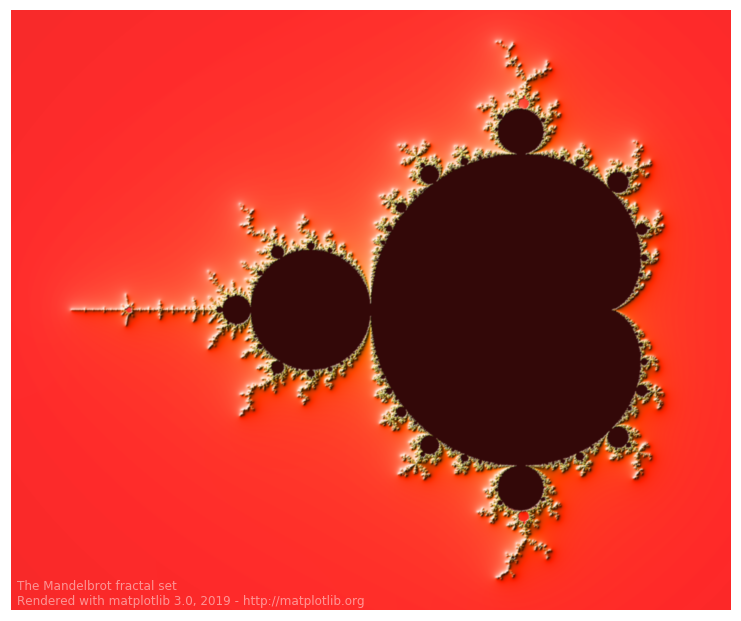

In [79]:
# Normalized recount as explained in:
# https://linas.org/art-gallery/escape/smooth.html
# https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift

# This line will generate warnings for null values but it is faster to
# process them afterwards using the nan_to_num
with np.errstate(invalid='ignore'):
    M = np.nan_to_num(N + 1 - np.log(np.log(abs(Z)))/np.log(2) + log_horizon)

dpi = 72
width = 10
height = 10*yn/xn
fig = plt.figure(figsize=(width, height), dpi=dpi)
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, aspect=1)

    # Shaded rendering
light = colors.LightSource(azdeg=315, altdeg=10)
M = light.shade(M, cmap=plt.cm.hot, vert_exag=1.5, norm=colors.PowerNorm(0.3), blend_mode='hsv')
plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
ax.set_xticks([])
ax.set_yticks([])

# Some advertisement for matplotlib
year = time.strftime("%Y")
major, minor, micro = matplotlib.__version__.split('.', 2)
text = ("The Mandelbrot fractal set\n" "Rendered with matplotlib %s.%s, %s - http://matplotlib.org" % (major, minor, year))
ax.text(xmin+.025, ymin+.025, text, color="white", fontsize=12, alpha=0.5)

plt.show()